# **Global Above-ground Live Woody Biomass Assessment**
<span style = "font-size: 1.5em;"> ***WHRC Pantropical National Level Carbon Stock Dataset in 2012*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

The assessment will estimate the above ground biomass (AGB) (ton C) in RoI and Remaining Forest in 2022. The AGB on Forest area is derived from overlay and masking analysis between WHRC Biomass dataset and Hansen Tree Cover.

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile

- Input Data Variables
> - **projectname (string)** : project name (example: "RVL_IDN_KubuRaya")
> - **projection**: UTM projection code in code (example: "EPSG:3857")
> - **roi_column_name** : variable name that specifiy unique ID for multipolygon analysis (example: "Name")

- Output directory folder
> - **output_directory** : select directory folder to put the output result

<span style="font-size:1.1em;"> ***Expected Output*** </span>
- Rasters dataset
> - WHRC Above ground biomass (Mg/Ha) in RoI and Forest extent in 2022

- csv, graph and maps 
> - Above ground biomass estimation in remaining forest extent area (Mg/Ha)
> - Above Ground Biomass distribution in remaining forest extent area

### <span style = "font-size: 1em;"> ***Brief Description of The Dataset*** </span>

A national-level map of above-ground live woody biomass density for tropical countries at 500m in 2012. This dataset was assembled from a combination of co-located field measurements, LiDAR observations, and imagery recorded from the Moderate Resolution Imaging Spectroradiometer (MODIS).


<span style="font-size:1.1em;"> ***Source*** </span>
- WHRC Pantropical National Level Carbon Stock Dataset in 2012
A. Baccini, S J. Goetz, W.S. Walker, N. T. Laporte, M. Sun, D. Sulla-Menashe, J. Hackler, P.S.A. Beck, R. Dubayah, M.A. Friedl, S. Samanta and R. A. Houghton. Estimated carbon dioxide emissions from tropical deforestation improved by carbon-density maps. 2012 Nature Climate Change, https://doi.org/10.1038/NCLIMATE1354


### <span style = "font-size: 1em;"> ***Note*** </span>

- WHRC biomass datasets represent the above ground biomass estimation in 2012

## Data Preparation

### Import modules and Relevant Datasets

In [1]:
%matplotlib inline
# Earth Engine Packages
import os
import ee
import geemap
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
from tkinter import * 
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from matplotlib import colors
from matplotlib.patches import Patch
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
import geoplot.crs as gcrs
import mapclassify as mc
import cartopy.io.img_tiles as cimgt
import shapely.wkt

In [2]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [4]:
# output directory
out_dir = os.path.expanduser(output_directory+'/RapidScreening_AGBiomassAssessment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Specify Input Data

In [5]:
###### 1 Specify project/region name, Forest threshold and projection
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.

# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")

#Specify forest_threshold
forest_threshold = simpledialog.askinteger("Input", "Specify forest threshold value to define forest",parent=root , 
                                           minvalue =0, maxvalue = 100)

if forest_threshold is not None:
    print("Forest is defined as area with >= ", forest_threshold, ' canopy cover')
else:
    print("Forest Threshold has not specified, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# Specify minimum mapping unit - forest
min_mapping_unit = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                           parent=root , minvalue =0, maxvalue = 100)

if min_mapping_unit is not None:
    print("Minimum mapping unit size is ", min_mapping_unit, ' pixels')
else:
    print("Minimum pixels size has not identified, Restart the code!")

pixels_mmu = ee.Number(min_mapping_unit)

# Specify column name in RoI attribute table
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Gabon RoI
Forest is defined as area with >=  30  canopy cover
All data will be reprojected to  EPSG:32732  canopy cover
Minimum mapping unit size is  12  pixels
Column name is  NAME


In [6]:
# tile scale to avoid memory ran out issue
tileScale = 4

### Visualisation Parameters

In [7]:
# Forest non forest map
vis_forestnonforest = {'palette': ['#008000']};

vis_biomass = {'min': 0.0, 'max': 350.0, 'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
                                                     '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
                                                     '012E01', '011D01', '011301'],};

# roi polygon
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

## Above Ground Biomass (AGB) Estimation in RoI and Remaining Forest Area

In [52]:
# Region of interest
roi = gpd.read_file(roi_directory.name)

# Reproject Shapefile to UTM and convert to ee.FeatureCollection
roi_proj  = roi.to_crs(crs=projection)

# Convert to ee.FeatureCollection for calculation process
roi_proj_gee = geemap.geopandas_to_ee(roi_proj, geodesic=False)

### Data Processing - Hansen Remaining Forest Area

In [53]:
# Import Hansen image dataset
Hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")

# Select bands
treeCover = Hansen.select(['treecover2000']);
lossImage = Hansen.select(['loss']);
gainImage = Hansen.select(['gain']);
lossImage_year = Hansen.select(['lossyear']);
landmask = Hansen.select(['datamask']);

In [54]:
# Reproject Image to UTM
treeCover_proj = treeCover.reproject(crs = projection, scale = 30)
lossImage_proj = lossImage.reproject(crs = projection, scale = 30)
lossImage_year_proj = lossImage_year.reproject(crs = projection, scale = 30)
landmask_proj = landmask.reproject(crs = projection, scale = 30)

In [55]:
# 1 Forest Map in 2000

## Define forest area by >= canopy cover
Hansen_Forest = treeCover_proj.gte(forest_threshold);
## Mask forest canopy cover threshold
Hansen_Forest_LandMasked = Hansen_Forest.updateMask(Hansen_Forest.eq(1)).updateMask(landmask_proj.eq(1));

## Apply smoothing with minimum area unit
Hansen_Forest_MinArea = Hansen_Forest_LandMasked.connectedPixelCount().gte(pixels_mmu).selfMask()

## Final forest cover in 2000
Hansen_Forest_firstPeriod = Hansen_Forest_LandMasked.updateMask(Hansen_Forest_MinArea);

In [56]:
# 2 Accumulative Forest Loss 2001-2021
maskerforestLos_0121 = lossImage_year_proj.gte(1);
## Set MMU to Estimate accumulative forest 2013-2021
forestLoss_0121 = lossImage_proj.updateMask(Hansen_Forest_firstPeriod).updateMask(landmask_proj.eq(1)).updateMask(maskerforestLos_0121);
contLoss = forestLoss_0121.connectedPixelCount().gte(pixels_mmu);
AccumForestLoss_0121 = forestLoss_0121.updateMask(contLoss);

In [57]:
# 3 Forest Cover in 2022
minLossUnmask_22 = AccumForestLoss_0121.unmask();
notLoss_22 = minLossUnmask_22.select('loss').eq(0);
Hansen_Remaining_Forest = Hansen_Forest_firstPeriod.updateMask(notLoss_22)

# Clip in roi
Hansen_Remaining_Forest_roi = Hansen_Remaining_Forest.clip(roi_proj_gee)

### Data Processing - WHRC Above Ground Biomass

In [58]:
# 1. Reproject WHRC Dataset
WHRC = ee.Image("WHRC/biomass/tropical")
WHRC_proj = WHRC.reproject(crs = projection, scale = 500)

In [59]:
# 2. Mask WHRC with roi and Remaining Forest
WHRC_roi_proj = WHRC_proj.clip(roi_proj_gee)
WHRC_RemainingForest_proj = WHRC_proj.updateMask(Hansen_Remaining_Forest_roi.eq(1))

In [60]:
# 3. Above ground biomass estimation
abv_biomass_roi = WHRC_roi_proj.select('Mg').multiply(25)
abv_biomass_RemainingForest = WHRC_RemainingForest_proj.select ('Mg').multiply(25)

### Interactive Map visualization

In [61]:
Map = geemap.Map()
Map.centerObject(roi_proj_gee, 10)

# 1 RoI and buffer
Map.addLayer(roi_proj_gee, vis_roi, "Region of Interest");
# 2 Remaining Forest
Map.addLayer(Hansen_Remaining_Forest_roi, vis_forestnonforest, "Forest/Non-forest 2022");
# 3. Above ground biomass 
Map.addLayer(WHRC_roi_proj, vis_biomass, 'WHRC-Biomass in RoI', False)
Map.addLayer(WHRC_RemainingForest_proj, vis_biomass, 'WHRC-Biomass in Forest 2022', True)

Map

Map(center=[0.4653966800280865, 9.583736496336329], controls=(WidgetControl(options=['position', 'transparent_…

### Export Results

In [44]:
# 1. Above ground Biomass

# a. Above ground biomass - RoI
AGB_roi_dir = os.path.join(out_dir, projectname + '_AGBiomass_roi.csv')
geemap.zonal_stats(
    abv_biomass_roi,
    roi_proj_gee,
    AGB_roi_dir,
    statistics_type='SUM',
    tile_scale = tileScale,
    scale = 500,
    crs = projection,
)

# b. Above ground biomass - Remaining Forest in 2022
AGB_RemainingForest_dir = os.path.join(out_dir, projectname + '_AGBiomass_RemainingForest.csv')
geemap.zonal_stats(
    abv_biomass_RemainingForest,
    roi_proj_gee,
    AGB_RemainingForest_dir,
    statistics_type='SUM',
    tile_scale = tileScale,
    scale = 500,
    crs = projection,
)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\SYSTEMIQ Ltd\GIS Tools - Documents\23_FEASIBILITY RVL_TZA_RUV - AUDD\Python Script\03 Comparison Number Checking All\03 Jupyter Calculation\RapidScreening_AGBiomassAssessment\Gabon RoI_AGBiomass_roi.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\SYSTEMIQ Ltd\GIS Tools - Documents\23_FEASIBILITY RVL_TZA_RUV - AUDD\Python Script\03 Comparison Number Checking All\03 Jupyter Calculation\RapidScreening_AGBiomassAssessment\Gabon RoI_AGBiomass_RemainingForest.csv


In [51]:
# 2. Above ground biomass Rasters

# a. Above ground biomass -Remaining Forest in 2022
geemap.ee_export_image_to_drive(
    abv_biomass_RemainingForest,
    description = projectname + '_AGBiomass_RemainingForest22',
    folder = projectname + '_BiomassAssessment',
    fileNamePrefix = projectname + '_AGBiomass_RemainingForest22',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

# b. Above ground biomass -RoI
geemap.ee_export_image_to_drive(
    abv_biomass_roi,
    description = projectname + '_AGBiomass_RoI',
    folder = projectname + '_BiomassAssessment',
    fileNamePrefix = projectname + '_AGBiomass_RoI',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

## Data Visualization

In [62]:
# 1. Above Ground Biomass in RoI and Forest Extent 2022
# 1.1 RoI
agb_roi_table = pd.read_csv(AGB_roi_dir.replace(os.sep,'/'))
agb_roi_table['Region'] = 'RoI'
# 1.2 Forest 2022
agb_forest22_table = pd.read_csv(AGB_RemainingForest_dir.replace(os.sep, '/'))
agb_forest22_table['Region'] = 'Forest extent in 2022'

In [63]:
# merge table
merge_agb_table = pd.concat([agb_roi_table, agb_forest22_table], ignore_index=True)

In [64]:
merge_agb_table

,sum,system:index,NAME,id,Region
0,10767.745098,0,Test_1,1,RoI
1,31714.313725,1,Test_2,2,RoI
2,4475.098039,2,Test_3,3,RoI
3,10767.745098,0,Test_1,1,Forest extent in 2022
4,31714.313725,1,Test_2,2,Forest extent in 2022
5,4106.274510,2,Test_3,3,Forest extent in 2022


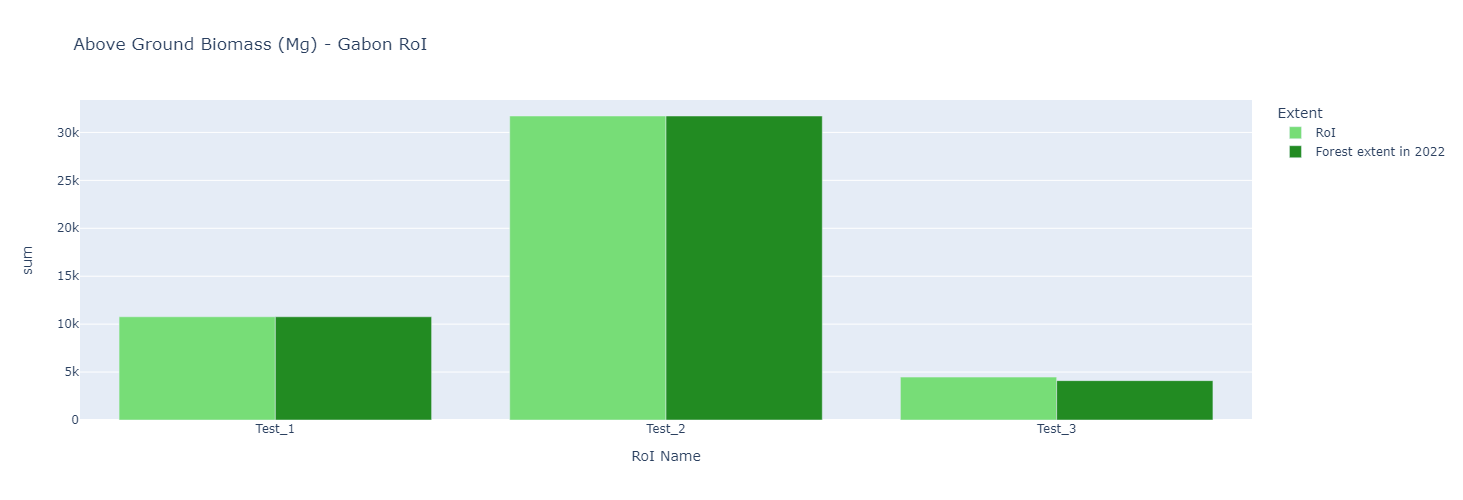

In [65]:
# Mangrove area in RoI
fig_AGBForest22 = px.bar(merge_agb_table, x = merge_agb_table[roi_column_name],
                      y = "sum", color = "Region", barmode = "group",
                      category_orders={"Extent": ["RoI","Forest extent in 2022"]},
                      color_discrete_sequence = ['#77dd77','#228b22'],
                      width=1400, height=500, 
                      labels = {roi_column_name: "RoI Name","Area_Ha": "mangrove Area (Ha)"},
                      title ="Above Ground Biomass (Mg) - " + projectname)
fig_AGBForest22.update_layout(legend_title_text='Extent')